# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [117]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [118]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [119]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

In [120]:
ex1 = sim.draws_pd()

In [121]:
mi_sim = ex1["mi"]
sigma_sim = ex1["sigma"]
height_sim = ex1["height_sim"]

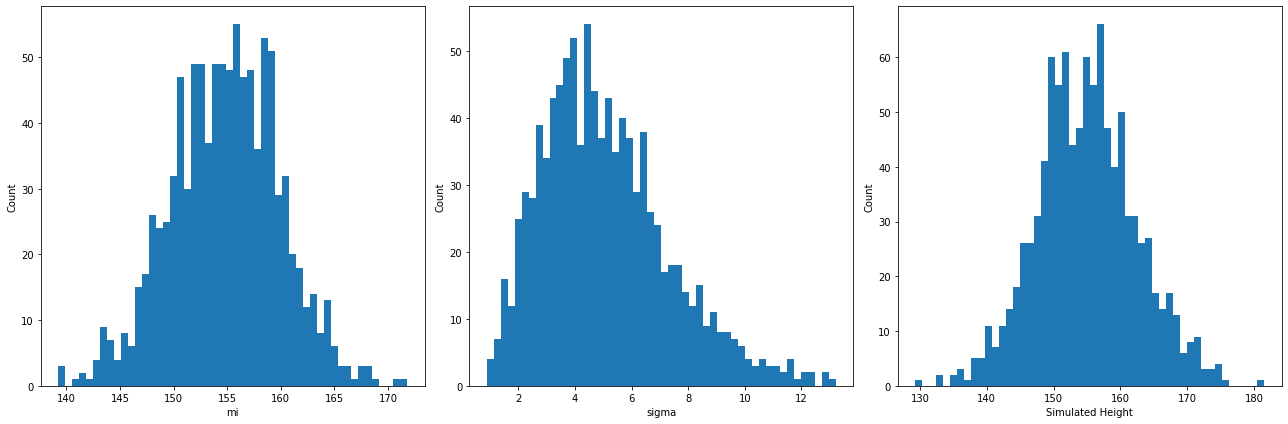

In [122]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
ax[0].hist(mi_sim, bins=50)
ax[0].set_xlabel("mi")
ax[0].set_ylabel("Count")
ax[1].hist(sigma_sim, bins=50)
ax[1].set_xlabel("sigma")
ax[1].set_ylabel("Count")
ax[2].hist(height_sim, bins=50)
ax[2].set_xlabel("Simulated Height")
ax[2].set_ylabel("Count")
plt.tight_layout()
plt.show()

## Task 2. Model fit and evaluation

In [123]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [124]:
fit=model_1_fit.sample(data=dict(N=len(d), heights=d.height.values), seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


<Figure size 720x720 with 0 Axes>

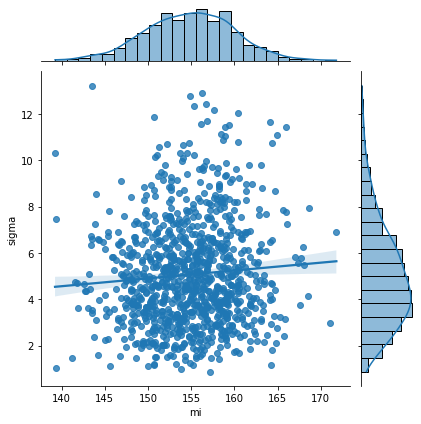

In [125]:
plt.figure(figsize=(10,10))
sns.jointplot(x = "mi", y = "sigma",
              kind = "reg", data = ex1,
              dropna = True)
plt.xlabel("mi")
plt.ylabel("sigma")
plt.show()

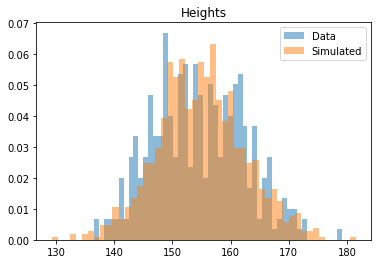

In [126]:
plt.figure()
plt.hist(d.height.values, bins=50, alpha=0.5, density=True)
plt.title('Heights')
plt.hist(height_sim, bins=50, alpha=0.5, density=True)

plt.legend(["Data","Simulated"]);

The Simulated and Real Data seems to be consistent. Model is valid.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [127]:
d['c_weight'] = d['weight'] - d['weight'].mean()
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}


## Task 4. Prior predictive checks
 

In [148]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

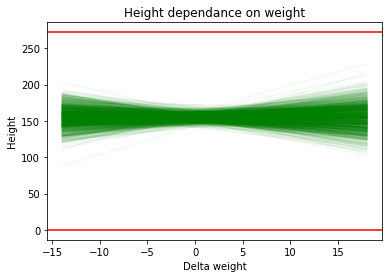

In [149]:
weight = np.linspace(d.c_weight.min(),d.c_weight.max(), R).reshape((R, 1))
h_hat = weight * sim.draws_pd()['beta'].values + sim.draws_pd()['alpha'].values
extended_domain = np.ones((1, R)) * weight
plt.plot(extended_domain, h_hat, 'g', alpha=0.05)
plt.title('Height dependance on weight')
plt.xlabel('Delta weight')
plt.ylabel('Height')
plt.axhline(y=0, color="red") #min height
plt.axhline(y=272, color="red") #max observed in nature
plt.show()

The data is consistent with assumtions about possible human height.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [168]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [169]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

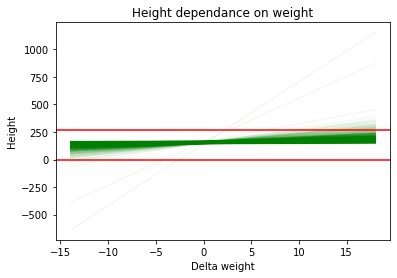

In [170]:
weight = np.linspace(d.c_weight.min(),d.c_weight.max(), R).reshape((R, 1))
h_hat = weight * sim.draws_pd()['beta'].values + sim.draws_pd()['alpha'].values
extended_domain = np.ones((1, R)) * weight
plt.plot(extended_domain, h_hat, 'g', alpha=0.05)
plt.title('Height dependance on weight')
plt.xlabel('Delta weight')
plt.ylabel('Height')
plt.axhline(y=0, color="red") #min height
plt.axhline(y=272, color="red") #max observed in nature
plt.show()

Most of the samples are within the assumed boundaries, however few of the are out of limits.

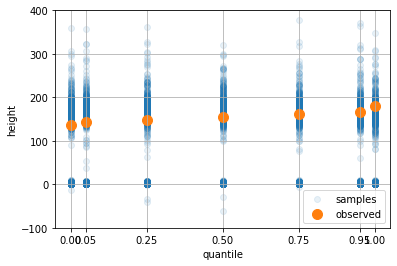

In [156]:
heights = sim.draws_pd().values
quantiles: list[float] = [.0, .05, .25, .5, .75, .95, 1.]


plt.scatter(quantiles * np.ones((1000, 1)), np.quantile(heights, quantiles, axis=1), alpha=0.1, label='samples')
plt.scatter(quantiles, np.quantile(d.height, quantiles), s=100, label='observed')
plt.xticks(quantiles)
plt.ylabel('height')
plt.xlabel('quantile')
plt.ylim([-100, 400])
plt.grid()
plt.legend()
plt.show()

## Task 6. Fitting and evaluating model


In [157]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan file /home/Lab4/height_2_fit.stan to exe file /home/Lab4/height_2_fit
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Lab4/height_2_fit.hpp /home/Lab4/height_2_fit.stan
Warning in '/home/Lab4/height_2_fit.stan', line 3, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/Lab4/height_2_fit.stan', line 4, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/Lab4/height_2_fit.stan', line 14, column 3: Declaration of
    arrays by placing brackets aft

1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [158]:
N = 50
data_fit = dict(N=N, heights=d.height.values[:N], weight=d.c_weight.values[:N])
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
3. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


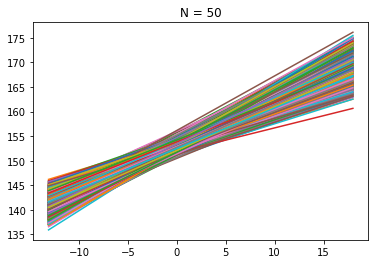

In [160]:
fit_pd = fit.draws_pd()
weights: np.ndarray = np.linspace(d.c_weight.values[:N].min(),d.c_weight.values[:N].max(), 1000)
heights = []
for i in range(4000):
    heights.append(fit_pd.alpha[i] + fit_pd.beta[i] * weights)
    plt.plot(weights, heights[i])
plt.title(f"N = {N}")
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


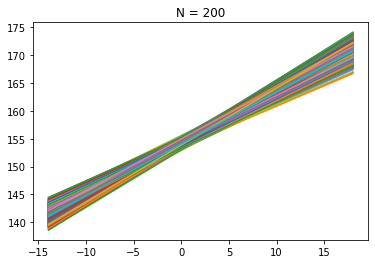

In [162]:
N2 = 200
data_fit2 = dict(N=N2, heights=d.height.values[:N2], weight=d.c_weight.values[:N2])
fit2=model_2_fit.sample(data=data_fit,seed=28052020)
fit_pd2 = fit.draws_pd()
weights: np.ndarray = np.linspace(d.c_weight.values[:N2].min(),d.c_weight.values[:N2].max(), 1000)
heights = []
for i in range(4000):
    heights.append(fit_pd.alpha[i] + fit_pd.beta[i] * weights)
    plt.plot(weights, heights[i])
plt.title(f"N = {N2}")
plt.show()

Uncertanity is getting lower along with increasing N parameter.

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


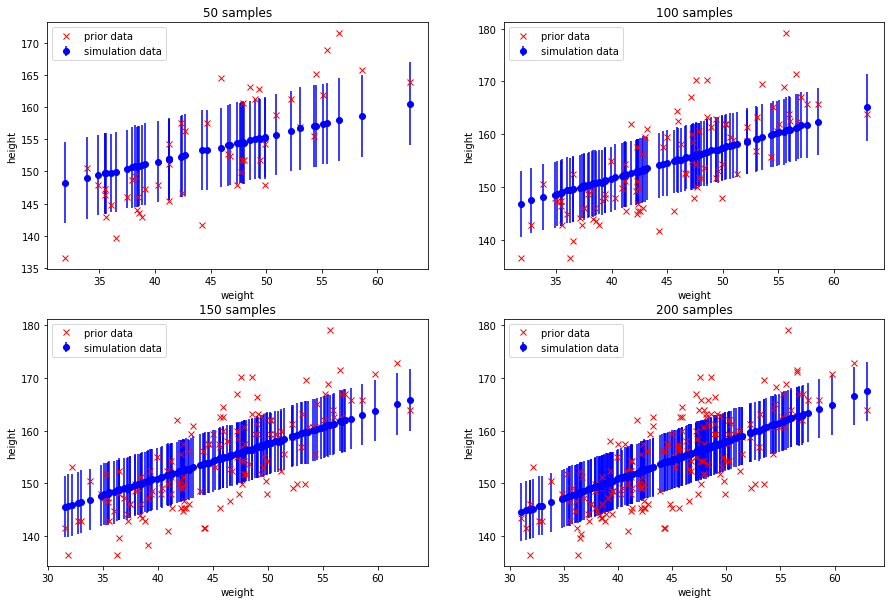

In [171]:
min_weight, max_weight = d.weight.min(),d.weight.max()

Ns = [50,100,150,200]

fig, axes = plt.subplots(2,2, figsize=(15,10))
axes = axes.ravel()

for number,N in enumerate(Ns):
    data_fit = {'N':N, 'heights':d.height.iloc[:N].values,\
        'weight':d.weight.iloc[:N].values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    model_2_fit_description = fit.draws_pd().describe()
    axes[number].errorbar(d["weight"].iloc[:N].values,model_2_fit_description.loc[["mean"]].iloc[:,-N:].to_numpy()[0],\
        yerr=model_2_fit_description.loc[["std"]].iloc[:,-N:].to_numpy()[0], \
        fmt='bo', label="simulated")
    axes[number].plot(d["weight"].iloc[:N].values,d.height.iloc[:N].values, 'rx', label="odserved")
    axes[number].set_title(f"{N} samples")
    axes[number].set_xlabel("weight")
    axes[number].set_ylabel("height")
    axes[number].legend()

While increasing N, error decreases.

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


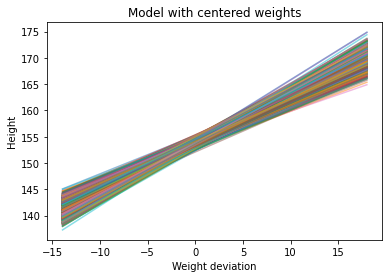

In [175]:
model_2_fit = CmdStanModel(stan_file='height_2_fit.stan')

minimal_weight = d["c_weight"].min()
maximal_wieght = d["c_weight"].max()

N = 150

data_fit = {'N':N, 'heights':d.height.iloc[:N].values,\
        'weight':d.c_weight.iloc[:N].values}

fit = model_2_fit.sample(data=data_fit,seed=28052020)

model_2_fit_draws = fit.draws_pd()

plt.plot([minimal_weight,maximal_wieght],\
[model_2_fit_draws["alpha"]+model_2_fit_draws["beta"]*minimal_weight,\
model_2_fit_draws["alpha"]+model_2_fit_draws["beta"]*maximal_wieght],\
alpha = 0.5)
plt.title('Model with centered weights')
plt.xlabel("Weight deviation")
plt.ylabel("Height")
plt.show()

INFO:cmdstanpy:compiling stan file /home/Lab4/height_2ndpower_pcc.stan to exe file /home/Lab4/height_2ndpower_pcc
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_2ndpower_pcc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Lab4/height_2ndpower_pcc.hpp /home/Lab4/height_2ndpower_pcc.stan
Warning in '/home/Lab4/height_2ndpower_pcc.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/Lab4/height_2ndpower_pcc.stan', line 11, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -


INFO:cmdstanpy:CmdStan done processing.


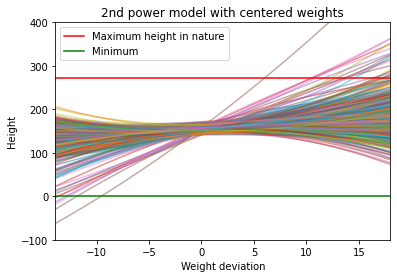

In [190]:
model_2ndpower_ppc=CmdStanModel(stan_file='height_2ndpower_pcc.stan')

minimal_weight = d["c_weight"].min()
maximal_weight = d["c_weight"].max()

weight_vector = np.linspace(minimal_weight,maximal_weight,100)

data_sim = data_sim={'N':100, 'weight':weight_vector}
model_2ndpower_ppc_sample= model_2ndpower_ppc.sample(data=data_sim, 
                     iter_sampling=500, 
                     seed=29042020)

model_2ndpower_ppc_draws = model_2ndpower_ppc_sample.draws_pd()

plot_x = np.linspace(minimal_weight, maximal_weight, 500)


for sample in range(500):
    plt.plot(plot_x, model_2ndpower_ppc_draws["alpha"][sample]+model_2ndpower_ppc_draws["beta1"][sample]*plot_x+model_2ndpower_ppc_draws["beta2"][sample]*plot_x*plot_x,alpha=0.5)

plt.axhline(y=272,label="Maximum height in nature",color='red')
plt.axhline(y=0,label="Minimum",color='green')
plt.title("2nd power model with centered weights")
plt.xlabel("Weight deviation")
plt.ylabel("Height")
plt.axis([minimal_weight,maximal_weight,-100,400])
plt.legend()
plt.show()

The 2nd power dependence on weight influence the extreme values, where preditions are over assumed limits.

INFO:cmdstanpy:compiling stan file /home/Lab4/height_2ndpower_fit.stan to exe file /home/Lab4/height_2ndpower_fit
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_2ndpower_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Lab4/height_2ndpower_fit.hpp /home/Lab4/height_2ndpower_fit.stan
Warning in '/home/Lab4/height_2ndpower_fit.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/Lab4/height_2ndpower_fit.stan', line 26, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -


INFO:cmdstanpy:CmdStan done processing.


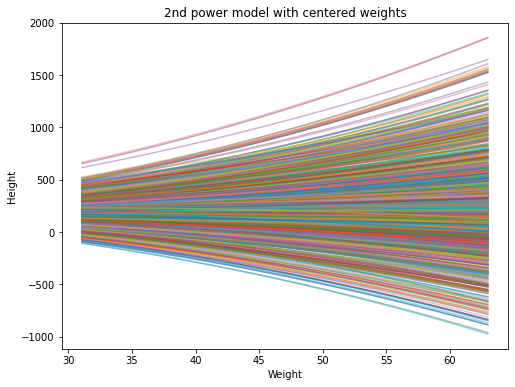

In [192]:
model_power_fit=CmdStanModel(stan_file='height_2ndpower_fit.stan')
N = 50
data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_power_fit.sample(data=data_fit,seed=28052020)

model_power_fit_draws = fit.draws_pd()
minimal_weight=d["weight"].min()
maximal_weight=d["weight"].max()
plot_x = np.linspace(minimal_weight, maximal_weight, 500)

plt.figure(figsize=(8,6))
for iter in range(1000):
    plt.plot(plot_x, model_power_fit_draws["alpha"][iter]+model_power_fit_draws["beta1"][iter]*plot_x+model_power_fit_draws["beta2"][iter]*(plot_x**2),alpha=0.5)
plt.title("2nd power model with centered weights")
plt.xlabel("Weight")
plt.ylabel("Height")
plt.show()

Because of the 2nd degree polynomial influence the values reached absourdous values. Linear model performed better.